The dataset for this project comes from a Minecraft research server operated by the Pacific Laboratory for Artificial Intelligence (PLAI), a computer science research group at UBC led by Professor Frank Wood. PLAI studies generative modeling, programming, and AI. Their PLAICraft initiative collects large-scale behavioral data from real players navigating a shared virtual server in Minecraft. Every player who joins the server contributes to a growing dataset that supports research on how humans play video games and how they interact within this specific environment.

Game analytics plays a central role in understanding how people interact with digital environments. By examining patterns in player activity such as a player's session frequency, duration, and engagement levels, we can further research about human behavior and AI to better predict resource allocation and user engagement. Since this server is an active research project rather than a commercial game, understanding player behavior and activity levels is essential so they can plan server hardware, storage, and data-processing resources effectively. Specifically, being able to identify which players engage the most with the game can support targeted recruitment and improved strategies for maintaining long-term engagement



This leads us to the central question of this project:

**Can player characteristics predict the total number of hours a player spends on the server?**

We will use **experience**, **gender**, and **Age** as explanatory variables to predict the response variable **played_hours**. These predictors were chosen because they are the only available player characteristics that could reasonably influence engagement patterns and help explain differences in total time spent on the server.

This project uses two datasets from the Minecraft research server: **players.csv** and **sessions.csv**.  
The **players** file contains 196 rows and 7 variables describing each participant, and the **sessions** file contains 1,535 rows documenting every recorded session.  
Below is a concise summary of all variables.


## Variables in `players.csv`

- **Age** – numeric, with 2 missing values  
- **gender** – categorical  
- **experience** – ordered categorical skill level  
- **played_hours** – numeric lifetime Minecraft hours (highly skewed)  
- **subscribe** – logical indicator of newsletter subscription  
- **name** – string player nickname  
- **hashedEmail** – string identifier used to link datasets  


## Variables in `sessions.csv`

- **start_time** – readable start timestamp  
- **end_time** – readable end timestamp, with 2 missing values  
- **original_start_time** – Unix start timestamp  
- **original_end_time** – Unix end timestamp  
- **hashedEmail** – player identifier linking to `players.csv`

## Issues and Notes

- Some missing values in both datasets  
- Large variation in lifetime hours and number of sessions per player  
- Self-reported values may include bias  
- Session logs may be incomplete or uneven  
- Voluntary participation may introduce selection bias  

By joining these tables on **hashedEmail**, we can link player characteristics to their session histories and total hours played, allowing us to build and evaluate predictive models.


## Data Loading and Wrangling


In [83]:
library(tidyverse)
library(tidymodels)
library(cowplot)

In [68]:
players_dataset <- read.csv("https://drive.google.com/uc?export=download&id=1uLgyqhTWde6lDwTPmpDHTHndMKkr0eGn")
head(players_dataset)
tail(players_dataset)

players_cleaned <- players_dataset |>
    select(Age, gender, experience, played_hours) |>
    mutate(gender = case_match
            (gender, "Male" ~ "Male", 
             "Female" ~ "Female", 
             .default = "Other")) |>
    mutate(experience = as_factor(experience), gender = as_factor(gender))
head(players_cleaned)
tail(players_cleaned)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
191,Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
192,Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
193,Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
194,Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
195,Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
196,Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


,Age,gender,experience,played_hours
,<int>,<fct>,<fct>,<dbl>
1,9,Male,Pro,30.3
2,17,Male,Veteran,3.8
3,17,Male,Veteran,0.0
4,21,Female,Amateur,0.7
5,21,Male,Regular,0.1
6,17,Female,Amateur,0.0


,Age,gender,experience,played_hours
,<int>,<fct>,<fct>,<dbl>
191,20,Male,Amateur,0.0
192,17,Female,Amateur,0.0
193,22,Male,Veteran,0.3
194,57,Other,Amateur,0.0
195,17,Male,Amateur,2.3
196,NA,Other,Pro,0.2


Loading in the dataset from a URL and then tidying the data by selecting the relavent columns - Age, gender, experience, and played_hours. We mutated the gender column so that all genders not listed as "Female" or "Male" are "Other," in order to succinctly visualize the data and infer from it. We also changed the data type of Experience and Gender to factors to also help with the visualization.

In [65]:
players_summarized <- players_cleaned |>
    summarize(Mean_age = mean(Age, na.rm = TRUE))
players_summarized

players_gender <- players_cleaned|>
    group_by(gender) |>
    summarise(count = n())
players_gender

Mean_age
<dbl>
21.13918


gender,count
<chr>,<int>
Female,37
Male,124
Other,35


Calculating summary statistics on the average gender of all players in the dataset, excluding NA values, which is 21.139 years. Also computed the count of how many players are in listed under each gender description. 

## Data Visualizations


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


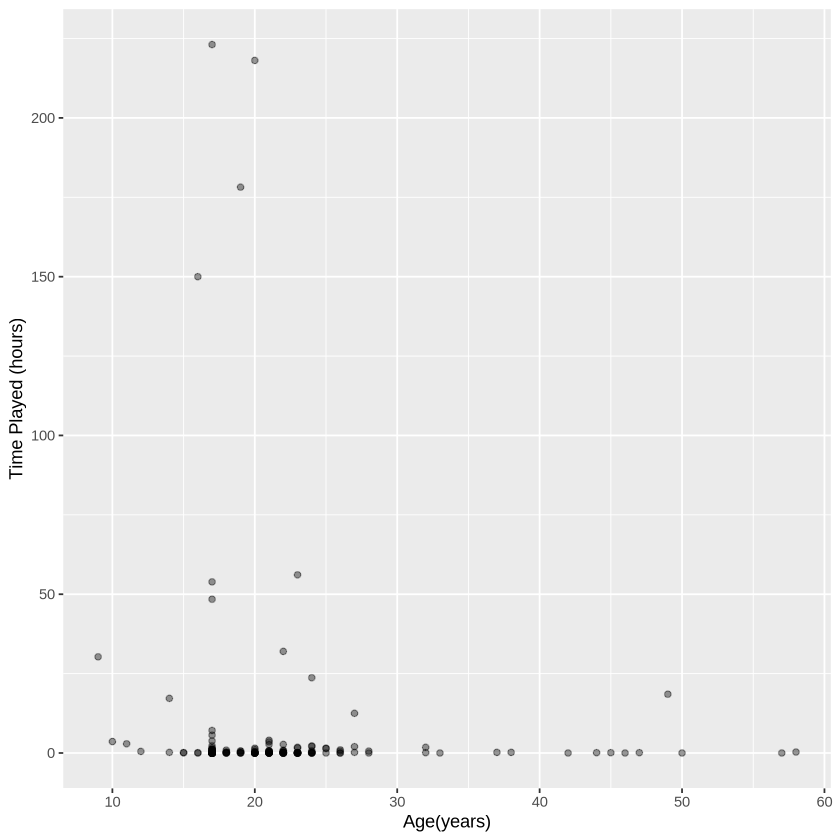

In [105]:
age_plot <- ggplot(players_cleaned, aes(x = Age, y = played_hours)) +
    geom_point(alpha = 0.4) +
    xlab("Age(years)") +
    ylab("Time Played (hours)")
age_plot

This scatterplot demonstrates the relationship between age and time played, and demonstrates that the age ranges from ~9 to ~57 years, and that the age with the most hours played is around 15-20. The opacity of the points also shows how there are many data entries with 0 hours.

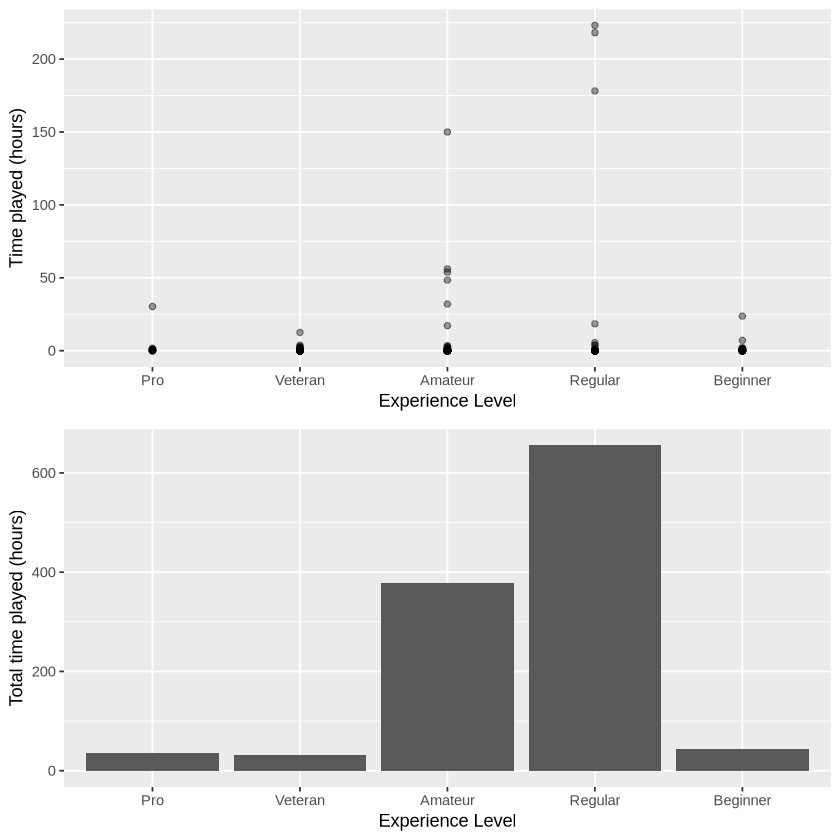

In [103]:
experience_plot <- ggplot(players_cleaned, aes(x = experience, y = played_hours)) +
    geom_point(alpha = 0.4) +
    xlab("Experience Level") +
    ylab("Time played (hours)")

experience_plot2 <- ggplot(players_cleaned, aes(x = experience, y = played_hours)) +
    geom_bar(stat = "identity") +
    xlab("Experience Level") +
    ylab("Total time played (hours)") 
plot_grid(experience_plot, experience_plot2, ncol = 1)

These plots visualize the relationship between experience and time played, demonstrating that the most played hours came from players in the Regular and Amateur experience classes, with significantly less from the Pro, Veteran, and Beginner levels. This could be because there are many more players in the amateur and regular groups therefore contributing more. 

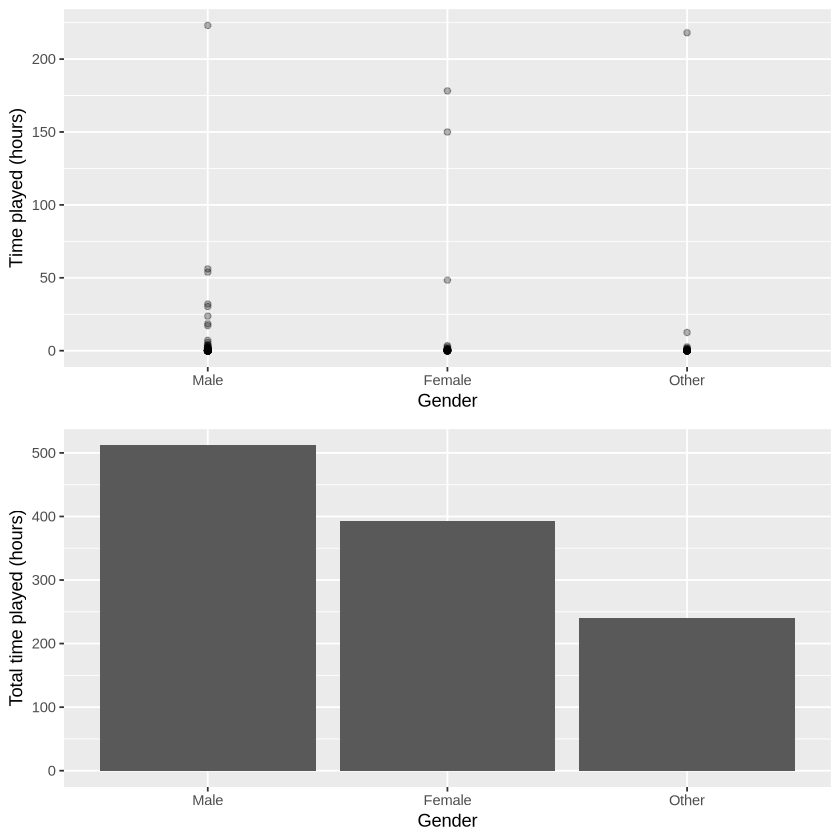

In [104]:
gender_plot <- ggplot(players_cleaned, aes(x = gender, y = played_hours)) +
    geom_point(alpha = 0.3) +
    xlab("Gender") +
    ylab("Time played (hours)")

gender_plot2 <- ggplot(players_cleaned, aes(x = gender, y = played_hours)) +
    geom_bar(stat = "identity") +
    xlab("Gender") +
    ylab("Total time played (hours)") 
plot_grid(gender_plot, gender_plot2, ncol = 1)

These visualizations demonstrate the relationship between gender and time played, showing that the amount of time played by each gender is very spread out, with low values of 0 and high values of 175-225 hours. It shows that the amount of time played by the Male gender is higher than Female and Other. Again, this could be because there are more males who contributed data than the other genders. 